Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


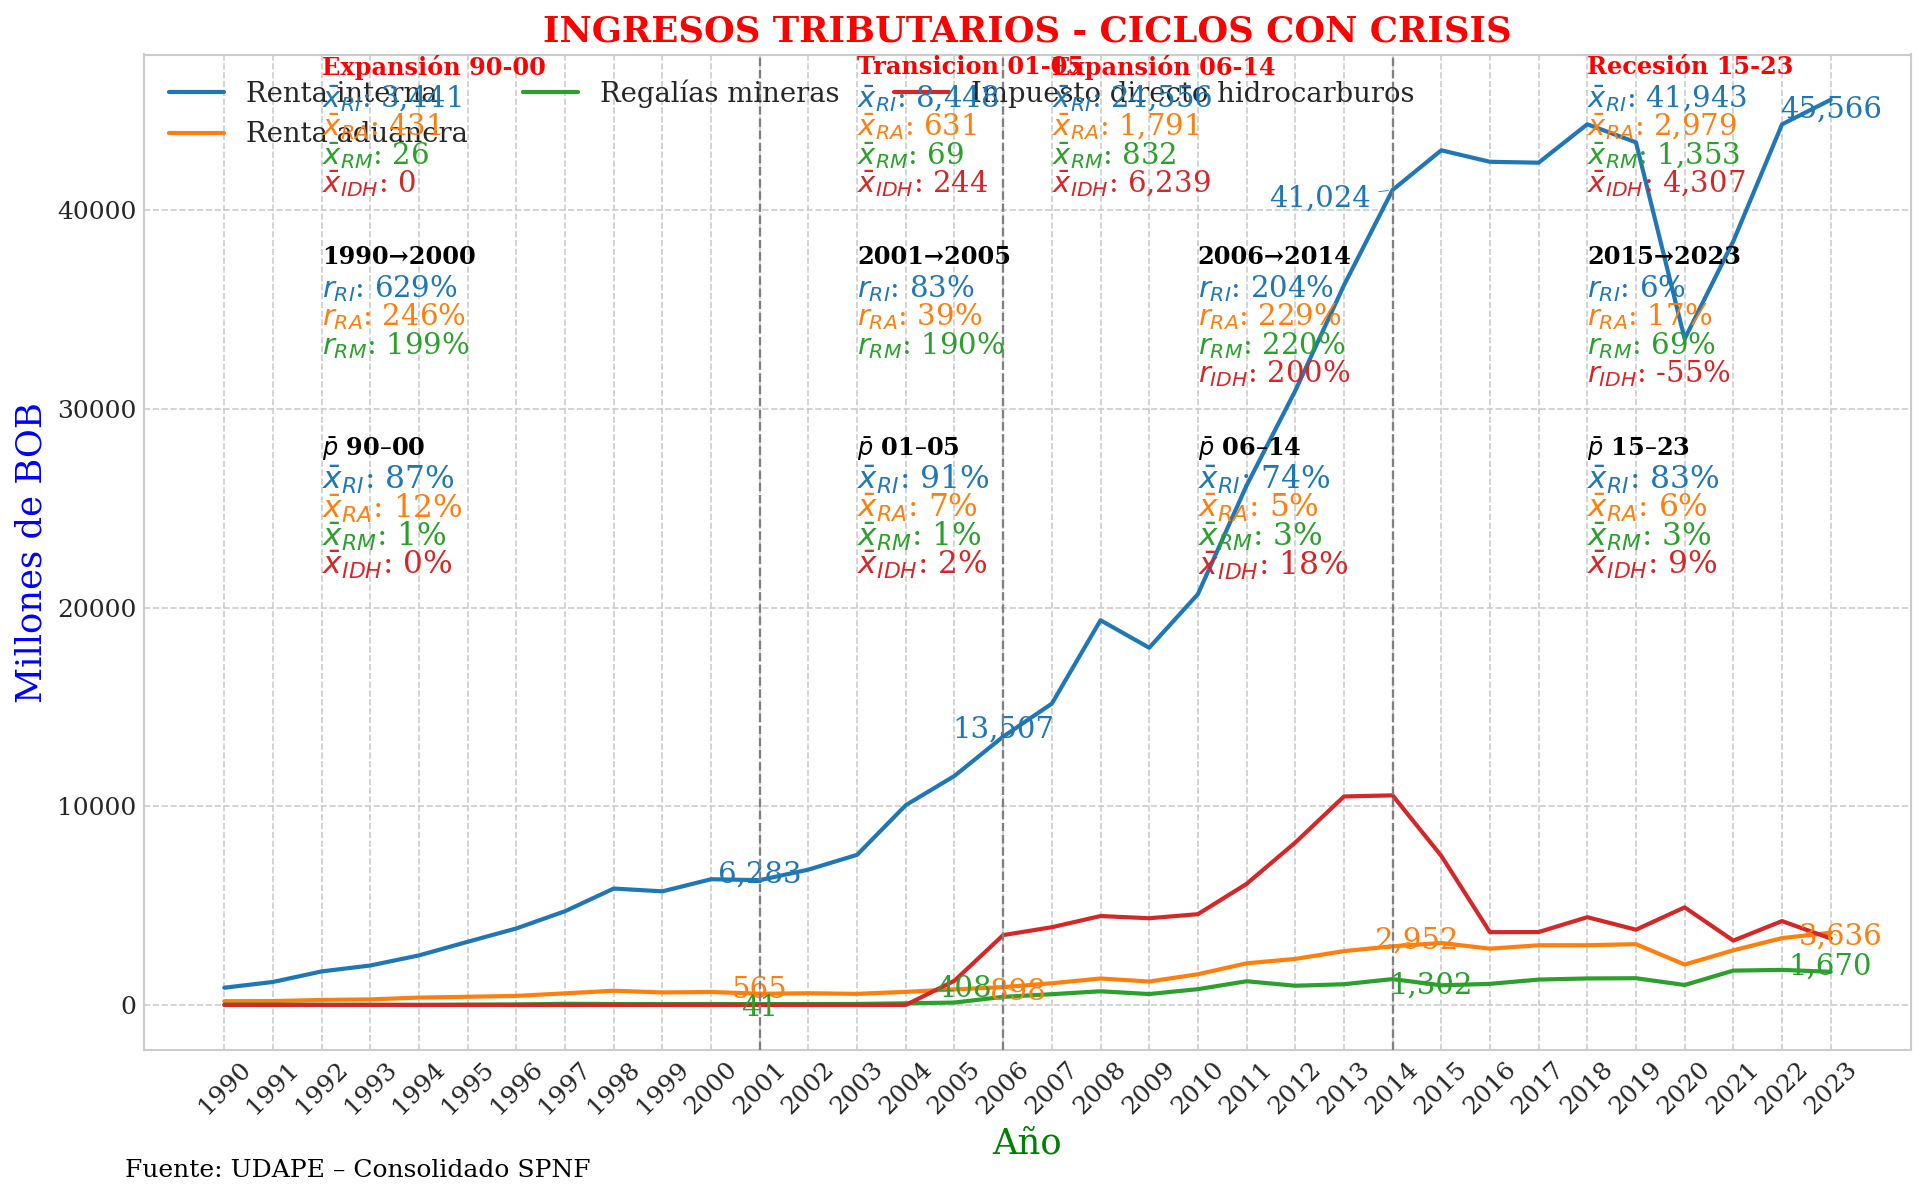

In [1]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones comunes
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# utilidades propias
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    set_style, init_base_plot, get_df,
    add_hitos, add_year_value_annotations,
    add_cycle_means_multi, add_period_growth_annotations_multi,
    add_participation_cycle_boxes,
    adjust_annot_years, adjust_cycles, adjust_periods,
)
from config import (
    CYCLES, annot_years, periodos_tasas, hitos_v
)

# Directorio de salida
dirs = os.path.abspath('../../../../assets/tesis/serie_completa/ingresos_tributarios')
os.makedirs(dirs, exist_ok=True)

set_style()

# %%
# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
SQL = '''
    SELECT año,
           renta_interna,
           renta_aduanera,
           regalias_mineras,
           impuesto_directo_hidrocarburos,
           ingresos_tributarios_total
    FROM ingresos_tributarios
'''
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (
        pd.read_sql(SQL, conn, index_col='año')
          .sort_index()
    )

# Componentes y colores
componentes = [
    ('renta_interna',    'Renta interna'),
    ('renta_aduanera',   'Renta aduanera'),
    ('regalias_mineras', 'Regalías mineras'),
    ('impuesto_directo_hidrocarburos', 'Impuesto directo hidrocarburos')
]
cols = [c for c,_ in componentes]
colors = {
    'renta_interna':    '#1f77b4',  # azul
    'renta_aduanera':   '#ff7f0e',  # naranja
    'regalias_mineras': '#2ca02c',  # verde
    'impuesto_directo_hidrocarburos': '#d62728',  # rojo
}
abbr = {
    'renta_interna':    'RI',
    'renta_aduanera':   'RA',
    'regalias_mineras': 'RM',
    'impuesto_directo_hidrocarburos': 'IDH',
}
TOTAL = 'ingresos_tributarios_total'

# Helper para offsets vacíos
def default_offsets(series, years, dx=0, dy=0):
    return {series: {y:(dx,dy) for y in years}}

# %%
# ─────────────────────────────────────────────────────────────────────
# 1) Gráfica con crisis
# ─────────────────────────────────────────────────────────────────────
# Años a anotar
years = adjust_annot_years(df, annot_years)
# Ciclos y estadísticas
cycles = adjust_cycles(df, CYCLES)
stats  = {n: df.loc[s, cols].mean().to_dict() for n,s in cycles.items()}
# Periodos para tasas y hitos
periodos = adjust_periods(df, periodos_tasas)
hitos    = hitos_v

# Offsets
annotation_offsets = {
    "renta_interna": {
        2001: (0,   300),
        2006: (0,   350),
        2014: (-1.5, -450),
        2023: (0,   -500),
    },
    "renta_aduanera": {
        2001: (0,    200),
        2006: (0.3, -250),
        2014: (0.5,  300),
        2023: (0.2, -200),
    },
    "regalias_mineras": {
        2001: (0,   -200),
        2006: (-0.8, 400),
        2014: (0.8, -350),
        2023: (0,    250),
    },
    "total": {
        2001: (0,    400),
        2006: (1.0,  450),
        2014: (-1.0,-500),
        2023: (0,    600),
    },
}
# 1) Offset de hitos (misma fracción para cada año en hitos_v)
hitos_offset = {
    1952: 0.85,
    1956: 0.85,
    1970: 0.85,
    1982: 0.85,
    1985: 0.85,
    2001: 0.85,
    2006: 0.85,
    2014: 0.85,
}

# 2) Posición de medias por ciclo (x = media de los años del slice, y = 1)
medias_offsets = {
    "Expansión 90-00":    (1992, 1),
    "Transicion 01-05":   (2003, 1),
    "Expansión 06-14":    (2007, 1),
    "Recesión 15-23":     (2018, 1),
}

# 3) Posición de etiquetas de crecimiento por periodo (x = punto medio, y = 0.8)
tasas_offsets = {
    "1990-2000": (1992, 0.8),
    "2001-2005": (2003, 0.8),
    "2006-2014": (2010, 0.8),
    "2015-2023": (2018, 0.8),
}

# 4) Offsets de cajas de participación (mismo x que tasas, y = 0.6)
participation_offsets = {
    "1990-2000": (1992, 0.6),
    "2001-2005": (2003, 0.6),
    "2006-2014": (2010, 0.6),
    "2015-2023": (2018, 0.6),
}

# Plot
fig, ax = init_base_plot(
    df, componentes, colors,
    'INGRESOS TRIBUTARIOS - CICLOS CON CRISIS',
    'Año', 'Millones de BOB',
    source_text='Fuente: UDAPE – Consolidado SPNF'
)
add_hitos(ax, df.index, hitos, hitos_offset)
add_year_value_annotations(
    ax, df, years, cols,
    annotation_offsets, colors, arrow_lw=0.4
)
add_cycle_means_multi(
    ax, stats, medias_offsets,
    abbr, colors, line_spacing=ax.get_ylim()[1]*0.03
)
add_period_growth_annotations_multi(
    ax, df, periodos, cols,
    tasas_offsets, colors, abbr
)
add_participation_cycle_boxes(
    ax, df, periodos, cols,
    TOTAL, participation_offsets,
    abbr_map=abbr, colors=colors
)

# Guardar
graf = os.path.join(dirs, 'ingresos_tributarios_crisis.png')
fig.savefig(graf)
plt.show()
plt.close(fig)

In [2]:
df

,renta_interna,renta_aduanera,regalias_mineras,impuesto_directo_hidrocarburos,ingresos_tributarios_total
año,,,,,
1990,867.6,188.8,16.5,0.0,1072.9
1991,1157.5,195.8,12.0,0.0,1365.3
1992,1687.8,252.1,11.1,0.0,1951.0
1993,1986.8,279.9,12.0,0.0,2278.7
1994,2495.1,370.8,0.0,0.0,2865.9
1995,3179.9,411.9,16.3,0.0,3608.1
1996,3852.9,455.8,25.3,0.0,4334.0
1997,4718.6,584.4,58.3,0.0,5361.3
1998,5859.3,715.4,48.0,0.0,6622.7
